In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn 
import os
import sys
import time

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
  print(module.__name__,module.__version__)


2.4.1
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.4.1
tensorflow.keras 2.4.0


In [4]:
imdb=keras.datasets.imdb
vocab_size=10000
index_from=3
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=vocab_size,index_from=index_from)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [5]:
word_index=imdb.get_word_index()
print(len(word_index))

1646592/1641221 [==============================] - 0s 0us/step
88584


In [6]:
word_index={k:(v+3) for k,v in word_index.items()}

In [7]:
word_index['<PAD>']=0
word_index['<START>']=1
word_index['<UNK>']=2
word_index['<END>']=3

reverse_word_index=dict([
    (value,key) for key,value in word_index.items()
])

def decode_review(text_ids):
    return ' '.join([reverse_word_index.get(word_id,'<UNK>') for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
max_length=500

train_data=keras.preprocessing.sequence.pad_sequences(
    train_data,value=word_index['<PAD>'],
    padding='post',maxlen=max_length
)

test_data=keras.preprocessing.sequence.pad_sequences(
    test_data,value=word_index['<PAD>'],
    padding='post',maxlen=max_length
)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [9]:
embedding_dim=16
batch_size=512
# 把DNN的全局平均换成单向RNN，时间变长，不断修改效果变好
# return_sequences:Boolean. Whether to return the last output in the output sequence, or the full sequence 文本生成、机器翻译是要返回所有序列的True,只要最后一个序列False
single_rnn_model=keras.models.Sequential([
          keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
          keras.layers.SimpleRNN(units=64,return_sequences=False),
          # w=64,b=64
          keras.layers.Dense(64,activation='relu'),
          keras.layers.Dense(1,activation='sigmoid'),
])

single_rnn_model.summary()
single_rnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# 全连接层参数是4160 wx+b:x是一维的64

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                5184      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [11]:
single_rnn_model.variables

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
 array([[ 0.00449119,  0.02070686,  0.0068997 , ...,  0.04604297,
         -0.04984387,  0.06260156],
        [-0.0305026 ,  0.03772903, -0.05363964, ...,  0.00419609,
         -0.08837022,  0.04351112],
        [-0.01304926, -0.00365975, -0.05816461, ...,  0.0539581 ,
         -0.01265259,  0.01860697],
        ...,
        [ 0.09478447,  0.03250819, -0.05579041, ..., -0.02697128,
          0.04991122,  0.02115705],
        [ 0.05750418, -0.04341195, -0.01529558, ..., -0.00182977,
          0.05234963,  0.10446138],
        [-0.00569711,  0.04980104,  0.0848233 , ..., -0.02797576,
         -0.06425454,  0.12084451]], dtype=float32)>,
 <tf.Variable 'simple_rnn/simple_rnn_cell/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[ 0.21597962,  0.10397592, -0.30522588, ...,  0.25914383,
         -0.21137181,  0.17291579],
        [-0.25902036,  0.14830989,  0.106616  , ..., -0.07380576,
         -0.08198777,

In [10]:
history_single_rnn=single_rnn_model.fit(
    train_data,train_labels,
    epochs=30,
    batch_size=batch_size,
    validation_split=0.2
)

Epoch 1/30
40/40 [==============================] - 21s 448ms/step - loss: 0.6938 - accuracy: 0.5044 - val_loss: 0.6939 - val_accuracy: 0.4912
Epoch 2/30
40/40 [==============================] - 17s 437ms/step - loss: 0.6917 - accuracy: 0.5101 - val_loss: 0.6944 - val_accuracy: 0.4930
Epoch 3/30
40/40 [==============================] - 17s 434ms/step - loss: 0.6919 - accuracy: 0.5120 - val_loss: 0.6926 - val_accuracy: 0.5224
Epoch 4/30
40/40 [==============================] - 18s 449ms/step - loss: 0.6900 - accuracy: 0.5160 - val_loss: 0.6946 - val_accuracy: 0.5010
Epoch 5/30
40/40 [==============================] - 18s 452ms/step - loss: 0.6849 - accuracy: 0.5296 - val_loss: 0.6944 - val_accuracy: 0.5184
Epoch 6/30
40/40 [==============================] - 17s 437ms/step - loss: 0.6872 - accuracy: 0.5126 - val_loss: 0.6924 - val_accuracy: 0.5082
Epoch 7/30
40/40 [==============================] - 18s 450ms/step - loss: 0.6827 - accuracy: 0.5262 - val_loss: 0.6945 - val_accuracy: 0.5098

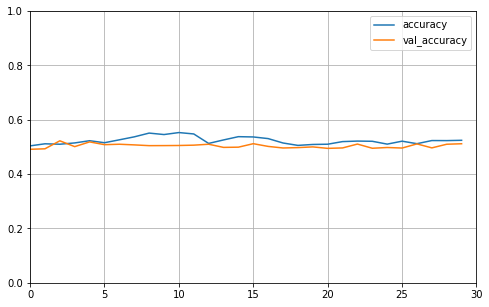

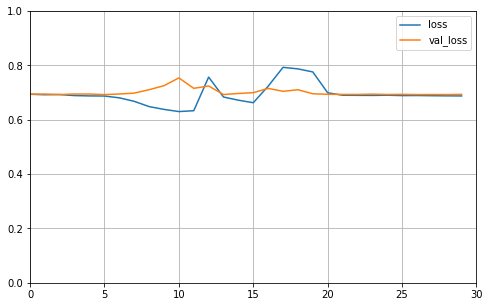

In [12]:
def plot_learning_curves(history,label,epochs,min_value,max_value):
  data={}
  data[label]=history.history[label]
  data['val_'+label]=history.history['val_'+label]
  pd.DataFrame(data).plot(figsize=(8,5))
  plt.grid(True)
  plt.axis([0,epochs,min_value,max_value])
  plt.show()


# 训练集、验证集上的准确率
plot_learning_curves(history_single_rnn,'accuracy',30,0,1)
# 训练集、验证集上的损失
plot_learning_curves(history_single_rnn,'loss',30,0,1)

In [13]:
single_rnn_model.evaluate(
    test_data,test_labels,
    batch_size=batch_size,
    verbose=0
)

[0.6937745809555054, 0.5047600269317627]

损失接近70%，准确率是50%—单向RNN没啥用

In [14]:
!nvidia-smi

Wed Mar  3 07:44:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    640MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# 改成双向RNN

embedding_dim=16
batch_size=512

model=keras.models.Sequential([
             keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
            #  增加数据，2层双向RNN
             keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64,return_sequences=True)),
             keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64,return_sequences=False)),
             keras.layers.Dense(64,activation='relu'),
             keras.layers.Dense(1,activation='sigmoid'),
             ])

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          10368     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [17]:
history=model.fit(train_data,train_labels,epochs=30,batch_size=batch_size,validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 61s 1s/step - loss: 0.6986 - accuracy: 0.5030 - val_loss: 0.6965 - val_accuracy: 0.5014
Epoch 2/30
40/40 [==============================] - 55s 1s/step - loss: 0.6937 - accuracy: 0.5159 - val_loss: 0.6946 - val_accuracy: 0.4954
Epoch 3/30
40/40 [==============================] - 55s 1s/step - loss: 0.6842 - accuracy: 0.5560 - val_loss: 0.7184 - val_accuracy: 0.5306
Epoch 4/30
40/40 [==============================] - 54s 1s/step - loss: 0.6134 - accuracy: 0.6586 - val_loss: 0.5986 - val_accuracy: 0.6950
Epoch 5/30
40/40 [==============================] - 56s 1s/step - loss: 0.3983 - accuracy: 0.8259 - val_loss: 0.5444 - val_accuracy: 0.7710
Epoch 6/30
40/40 [==============================] - 56s 1s/step - loss: 0.1960 - accuracy: 0.9250 - val_loss: 0.6676 - val_accuracy: 0.7580
Epoch 7/30
40/40 [==============================] - 55s 1s/step - loss: 0.0926 - accuracy: 0.9695 - val_loss: 0.8361 - val_accuracy: 0.7524
Epoch 8/30
40/40 [==

在训练集上准确率能达到100%，就足够说明模型强大了

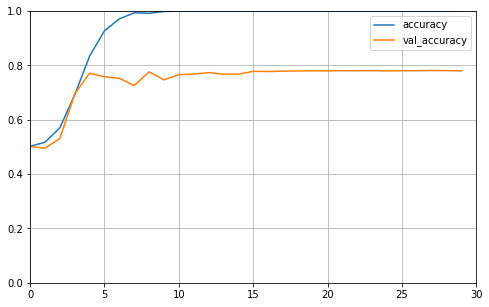

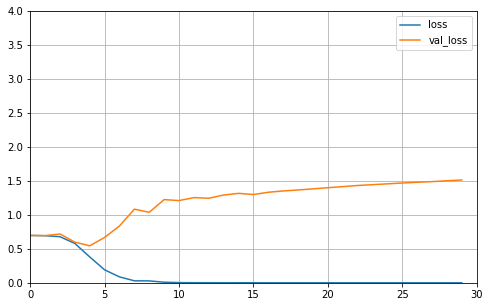

In [18]:
plot_learning_curves(history,'accuracy',30,0,1)
plot_learning_curves(history,'loss',30,0,4)

过拟合了，可能是模型太复杂，改为单层的RNN

In [19]:
# 改成双向RNN

embedding_dim=16
batch_size=512

model=keras.models.Sequential([
             keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
            #  增加数据，2层双向RNN
             keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64,return_sequences=True)),
            #  keras.layers.Bidirectional(keras.layers.SimpleRNN(units=64,return_sequences=False)),
             keras.layers.Dense(64,activation='relu'),
             keras.layers.Dense(1,activation='sigmoid'),
             ])

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 128)          10368     
_________________________________________________________________
dense_4 (Dense)              (None, 500, 64)           8256      
_________________________________________________________________
dense_5 (Dense)              (None, 500, 1)            65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________


In [20]:
history=model.fit(train_data,train_labels,epochs=30,batch_size=batch_size,validation_split=0.2)

Epoch 1/30
40/40 [==============================] - 30s 726ms/step - loss: 0.6948 - accuracy: 0.5064 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 2/30
40/40 [==============================] - 29s 732ms/step - loss: 0.6930 - accuracy: 0.5058 - val_loss: 0.6830 - val_accuracy: 0.5543
Epoch 3/30
40/40 [==============================] - 28s 694ms/step - loss: 0.6894 - accuracy: 0.5357 - val_loss: 0.6625 - val_accuracy: 0.5921
Epoch 4/30
40/40 [==============================] - 29s 731ms/step - loss: 0.6465 - accuracy: 0.6271 - val_loss: 0.6418 - val_accuracy: 0.6366
Epoch 5/30
40/40 [==============================] - 29s 725ms/step - loss: 0.5944 - accuracy: 0.7007 - val_loss: 0.6266 - val_accuracy: 0.6186
Epoch 6/30
40/40 [==============================] - 29s 732ms/step - loss: 0.6086 - accuracy: 0.6213 - val_loss: 0.6170 - val_accuracy: 0.6129
Epoch 7/30
40/40 [==============================] - 27s 686ms/step - loss: 0.5848 - accuracy: 0.6374 - val_loss: 0.6618 - val_accuracy: 0.6755

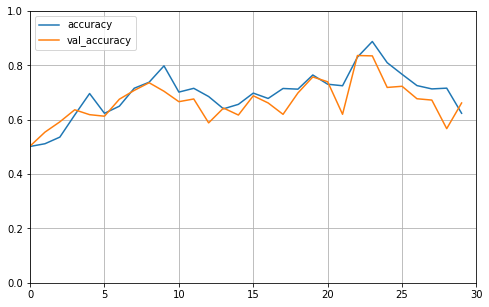

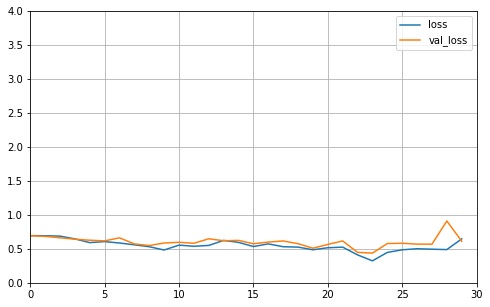

In [21]:
plot_learning_curves(history,'accuracy',30,0,1)
plot_learning_curves(history,'loss',30,0,4)

In [22]:
model.evaluate(test_data,test_labels,batch_size=batch_size,verbose=0)

[0.6199244856834412, 0.6565762758255005]

与单层RNN相比loss减少，accuracy上升，效果变好；但是仍然是过拟合的，可以看作模型强大